# To visualize approaches

A simulated dataset is made to vizualize the filtering performed by the clustering approaches and the 

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src/models')
import bootstrapped_ensemble_cluster_filter as BE_cluster_filter
import helper

from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


import pprint
figure_path = module_path + '/figures/cluster_filter/'

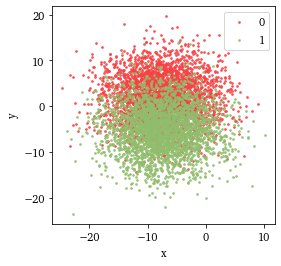

In [2]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=6000, centers=2, n_features=2, cluster_std = 5, random_state = 43)
# scatter plot, dots colored by class value

X, y = pd.DataFrame(X), pd.Series(y)

y = y.astype(int)
X.columns = np.arange(len(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

f = helper.scatterplot_with_colors(X.values, y.values)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

k_range = list(range(1,8))
cluster_range = list(range(10,15))
thresh_range = [8]

weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {
    'knnOptimal': clf,
    'nb': GaussianNB()
}

clf_dict = {'knnOptimal': KNeighborsClassifier(n_neighbors=7), 'nb': GaussianNB()}

grid_dict = {
    'knnOptimal': grid
}
start = time()
param_dict = BE_cluster_filter.hyperparam_search_accuracy(X_train, y_train, X_val, y_val,
                                   clf_dict, 
                                   clusters_list = cluster_range,
                                  thresh_list = thresh_range)
print(f'Time used: {time() - start}')
pprint.pprint(param_dict, depth = 2)

/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.

Time used: 9.332036018371582
{'knnOptimal': {'custers': 10,
                'keep clusters': array([0, 1, 5, 6, 7, 8]),
                'threshold': 8},
 'nb': {'custers': 13,
        'keep clusters': array([ 2,  4,  5,  6,  8,  9, 11]),
        'threshold': 8}}


### Test set filtering

/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +


AUC score for the initial classifiers: 
{'knnOptimal': 0.7469177663394514, 'nb': 0.7602972729597226}
AUC score for the filtered dataset: 
{'knnOptimal': 0.8497840913676904, 'nb': 0.8775850640742378}


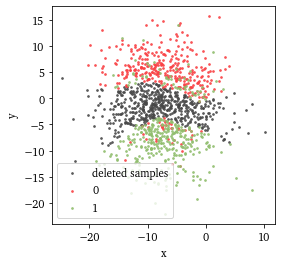

In [5]:
_, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train, y_train, X_test, y_test, clf_dict,
                                     param_dict = param_dict)


auc_init, auc_filtered, _ = helper.get_auc_scores(X_test, y_test, clf_dict, indices)
print('AUC score for the initial classifiers: ')
pprint.pprint(auc_init)
print('AUC score for the filtered dataset: ')
pprint.pprint(auc_filtered)


mask=np.full(len(y_test),True,dtype=bool)
mask[indices['knnOptimal']]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f, ax = helper.scatterplot_with_colors(X_test.values, new_y_test.values)
#f.savefig(figure_path + 'simulated_data_cluster_filtered.pdf', bbox_inches='tight')

plt.show()

# Adding noise

In [6]:
new_X, n_idx= BE_cluster_filter.add_noise_dataset(X_test, 20, 3)

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

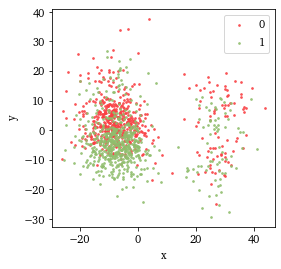

In [7]:
helper.scatterplot_with_colors(new_X.values, y_test.values)

#f.savefig(figure_path + 'simulated_data_with_noise_cluster_not_filtered.pdf', bbox_inches='tight')

/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +


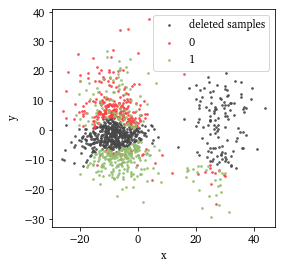

In [8]:
_, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train, y_train, new_X, y_test, clf_dict, param_dict = param_dict)


name = 'nb'
mask=np.full(len(new_X),True,dtype=bool)
mask[indices[name]]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = helper.scatterplot_with_colors(new_X.values, new_y_test.values)

#f.savefig(figure_path + 'simulated_data_with_noise_cluster_filtered.pdf', bbox_inches='tight')

# Gradually adding more noise

In [9]:
ampl_list = [5, 10, 15, 20, 25, 30, 35, 40]
filtered = {}
init = {}
removed_data = {}
for ampl in ampl_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, ampl, 4)
    
    _, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    auc_init, auc_filtered, rm_data = helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[ampl] = auc_filtered
    init[ampl] = auc_init
    removed_data[ampl] = rm_data


a_file = open(module_path + '/src/models/dictionaries_filter_results/simulated_cluster_amplitude.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()

/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.

In [10]:
amount_list = [12, 10, 7, 5, 4, 3, 2] # Is invertly large --> 3 means more noise is added than 4
filtered = {}
init = {}
removed_data = {}

for am in amount_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, 15, am)
    
    
    _, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    auc_init, auc_filtered , rm_data= helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[am] = auc_filtered
    init[am] = auc_init
    removed_data[am] = rm_data



a_file = open(module_path + '/src/models/dictionaries_filter_results/simulated_cluster_amount.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()

/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.py:197: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +
/home/andrine/anaconda3/lib/python3.7/site-packages/minisom.